# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

## Notes

* The author used the full ImageNet dataset. I did not want to use the full dataset so I decided to use a subset.
    * so I used this project: https://github.com/mf1024/ImageNet-datasets-downloader to create a subset of the ImageNet dataset. I used this to create a small subset. The purpose of the small subset is to test the remainder of the notebook without having to wait for the extended amount of time it would take to use the full ImageNet dataset. I know ther results won't be good, but it will help me flesh out this JupyterNotebook.
    * The code from `ImageNet-data-set-downloader` does not split the images into the required `train`, `test`, `validation` directories. That is done with other scripts outside this notebook. This notebook assumes that the data is available with that split. It will not work otherwise. 


* If we use the full ImageNet dataset, splitting the data should not be needed. I believe that the ImageNet dataset comes already split into the appropriate directory types.


* The full ImagNet set can be downloaded via Kaggle. Join competition. https://www.kaggle.com/c/imagenet-object-localization-challenge/data. Be aware that this is 155G of data!


* I modified some of the set up code to make it fit my environment. This will have to be modified if this notebook is run elsewehre. All of the paths and pointers to the training data are in the cell labeled *Training Dataset* bellow.


* Split cells into more functionally isolated cells. i.e separated package imports

## TO DO

* Train with a larger Imagenet dataset

* Complete the training on the full ImageNet. Download this from Kaggle or use the max options with the current `Image-data-set-downloader`

* The Examples section at the end of the notebook generate the results to disk. Add a set of cells that can be optionally run that would instead display the images: damaged, predicted and original images.

* Train on the CelebA dataset. This is really what we will need for the mobile use case.

* Refactor some of the cells - there is too much being done in a single cell. Split. It makes it easier to read and debug.

* Sort out the 'fine tuning' aspects of this work

* 

In [1]:
import os
import gc
import datetime
import numpy as np
import pandas as pd
import cv2

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

# Change to the project root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')
    
from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2
plt.ioff()

# Training Dataset

In [15]:
TRAIN_DIR = r"/home/edm/work/mldata/small-imagenet_1000/imagenet_images_1000_811/train/"
VAL_DIR = r"/home/edm/work/mldata/small-imagenet_1000/imagenet_images_1000_811//"
TEST_DIR = r"/home/edm/work/mldata/small-imagenet_1000/imagenet_images_1000_811/test/"

BATCH_SIZE = 4

# Creating train & test data generator

In [16]:
class AugmentingDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, mask_generator, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)        
        seed = None if 'seed' not in kwargs else kwargs['seed']
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample            
            mask = np.stack([
                mask_generator.sample(seed)
                for _ in range(ori.shape[0])], axis=0
            )

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

## Create Training Generator

train_datagen = AugmentingDataGenerator(  
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    MaskGenerator(512, 512, 3),
    target_size=(512, 512), 
    batch_size=BATCH_SIZE
)

## Create Validation Generator

val_datagen = AugmentingDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, 
    MaskGenerator(512, 512, 3), 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    classes=['val'], 
    seed=42
)

## Create Testing Generator

test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    MaskGenerator(512, 512, 3), 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    seed=42
)

## Take a look at images and how they would look

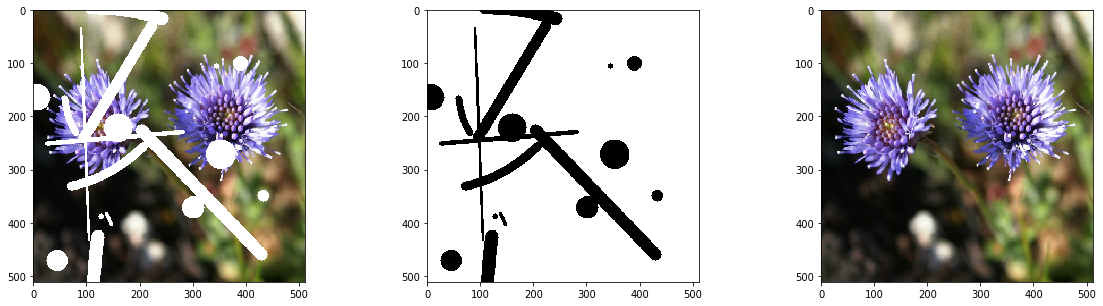

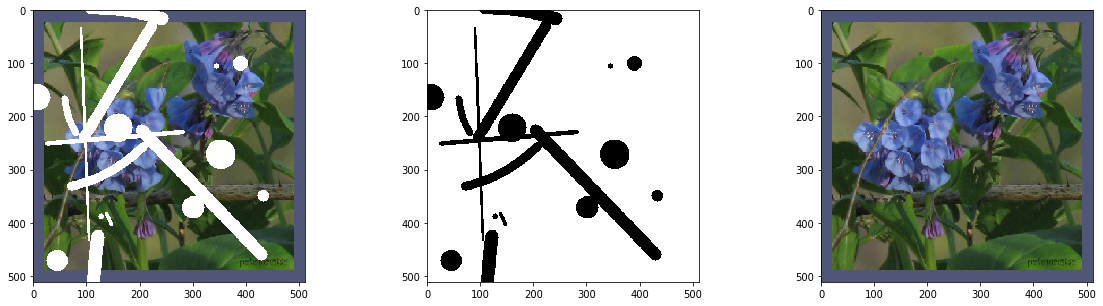

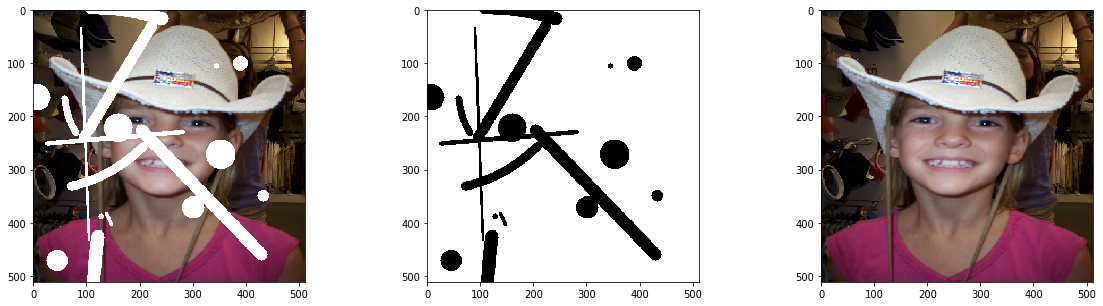

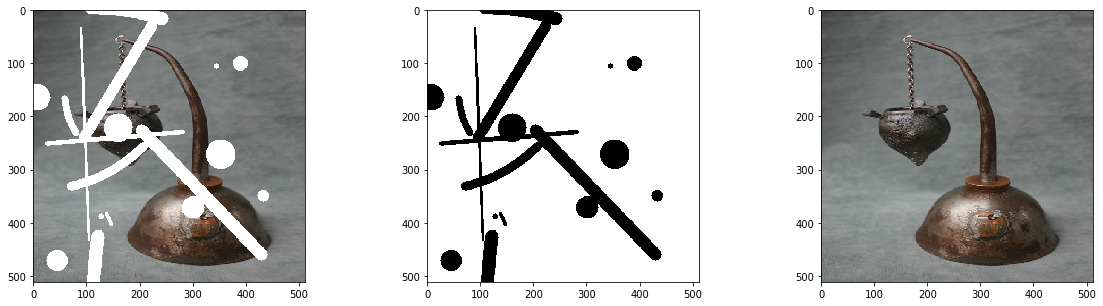

In [26]:
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [20]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [27]:
# Instantiate the model
model = PConvUnet(vgg_weights="/home/edm/work/dev/PConv-Keras/data/logs/pytorch_to_keras_vgg16.h5")
#model.load(r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\single_image_test\weights.10-0.89.h5")
model.load(r"/home/edm/work/dev/PConv-Keras/data/logs/imagenet_phase1_paperMasksweights.43-4.33.h5")

In [28]:
FOLDER = './data/logs/imagenet_phase1_paperMasks'

# Run training for certain amount of epochs
model.fit_generator(
    train_generator, 
    #steps_per_epoch=10000,
    steps_per_epoch=100,
    validation_data=val_generator,
    #validation_steps=1000,
    validation_steps=100,
    #epochs=50,  
    epochs=50,
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            FOLDER+'weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)

## Phase 2 - without batch normalization

In [ ]:
# Load weights from previous run
#model = PConvUnet(vgg_weights='./data/logs/pytorch_vgg16.h5')
model = PConvUnet(vgg_weights='./data/logs/pytorch_to_keras_vgg16.h5')

model.load(
    r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase1\weights.23-1.18.h5",
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Run training for certain amount of epochs
model.fit_generator(
    train_generator, 
    #steps_per_epoch=10000,
    steps_per_epoch=10,
    validation_data=val_generator,
    #validation_steps=1000,
    validation_steps=10,
    #epochs=50,  
    epochs=5, 
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/imagenet_phase2',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/imagenet_phase2/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)

## Phase 3 - Generating samples
Let us use the fine-tuned network to get some sample. We will save results in `data/test_samples` folder

In [29]:
# Load weights from previous run
model = PConvUnet()
model.load(
    #r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase2\weights.26-1.07.h5",
    #"/home/edm/work/dev/PConv-Keras/data/logs/imagenet_phase1_paperMasksweights.04-8.92.h5",
    #r"/home/edm/work/dev/PConv-Keras/data/logs/imagenet_phase1_paperMasksweights.43-4.33.h5",
    r"/home/edm/work/dev/PConv-Keras/data/logs/imagenet_phase1_paperMasksweights.43-4.33.h5",
    train_bn=False,
    lr=0.00005
)

In [30]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    #if n > 100:
    if n > 100:
        break

25it [00:23,  1.12it/s]

# Section Below not needed for now

# Performance Evaluation
To evaluate the performance of the network, in this notebook I'll try loading the test masks used in the original paper, and see which PSNR scores we get on imagenet 

In [ ]:
# Store data
ratios = []
psnrs = []

# Loop through test masks released with paper
test_masks = os.listdir('./data/masks/test')
for filename in tqdm(test_masks):
    
    # Load mask from paper
    filepath = os.path.join('./data/masks/test', filename)
    mask = cv2.imread(filepath) / 255
    ratios.append(mask[:,:,0].sum() / (512 * 512))
    mask = np.array([1-mask for _ in range(BATCH_SIZE)])
    
    # Pick out image from test generator
    test_data = next(val_generator)
    (_, _), ori = test_data
    
    masked = deepcopy(ori)
    masked[mask==0] = 1
    
    # Run prediction on image & mask
    pred = model.predict([ori, mask])
    
    # Calculate PSNR
    psnrs.append(-10.0 * np.log10(np.mean(np.square(pred - ori))))

In [ ]:
df = pd.DataFrame({'ratios': ratios[:2408], 'psnrs': psnrs})

means, stds = [], []
idx1 = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
idx2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for mi, ma in zip(idx1, idx2):
    means.append(df[(df.ratios >= mi) & (df.ratios <= ma)].mean())
    stds.append(df[(df.ratios >= mi) & (df.ratios <= ma)].std())
    
pd.DataFrame(means, index=['{}-{}'.format(a, b) for a, b in zip(idx1, idx2)])